# Getting started

First, download the required packages:

```
pip install numpy torch torchvision matplotlib pillow
```

Next, the data and pretrained model can de downloaded by running the following cell.

In [ ]:
! mkdir pretrained && cd pretrained && wget https://www.dropbox.com/s/bwony66q5gdkb3r/bicnet_85000.pth
! mkdir data && cd data && wget https://www.dropbox.com/s/wc8vyoxhvjhl22n/orex_sandpiper.zip && unzip orex_sandpiper.zip

# Run segmentation

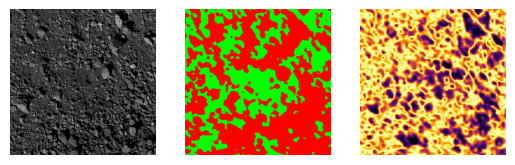

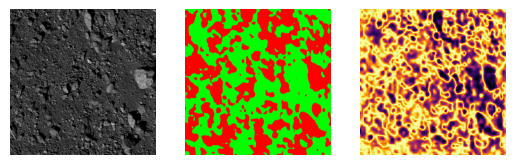

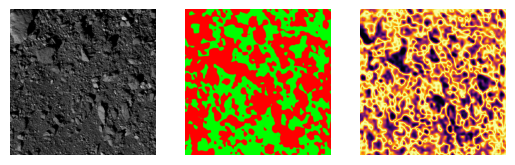

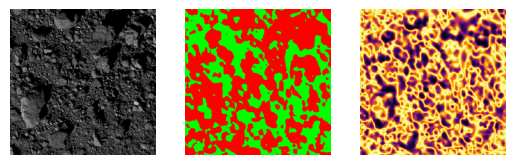

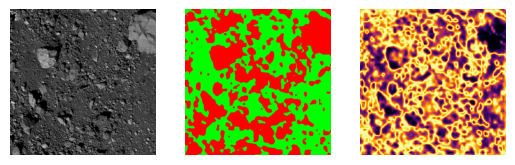

In [1]:
import os

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from models.bicnet import BICNet

MC_RUNS = 8

# Load model.
model = BICNet(3, 2)
model_path = "pretrained/bicnet_85000.pth"
if model_path is not None:
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# Initialize data directories.
data_dir = "data/orex_sandpiper/ocams_recon"
img_dir = os.path.join(data_dir, "images")
os.makedirs(os.path.join(data_dir, "init"), exist_ok=True)
os.makedirs(os.path.join(data_dir, "entropy"), exist_ok=True)
image_paths = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]

for img_path in image_paths[:5]:

    # Load image.
    img = Image.open(img_path).convert("RGB")
    img_numpy = np.array(img)
    fname = os.path.split(img_path)[1].replace("png", "npy")

    img = T.ToTensor()(img)
    img = torch.FloatTensor(img)
    img = torch.unsqueeze(img, 0)
    n, c, h, w = img.size()  # (batch_size, num_class, height, width)

    # Monte-Carlo Run --
    # p is probability to be each class after M stochastic forward passes
    p = torch.zeros(1, 2, h, w)  # (shape: (batch_size, num_classes, h, w))
    for _ in range(MC_RUNS):
        with torch.no_grad():
            logit = model(img)
        p += F.softmax(logit, dim=1) / MC_RUNS  # take average

    # p -> prediction
    pred = torch.argmax(p, axis=1)  # (b, h, w)
    pred_npy = pred[0].cpu().numpy().astype(np.int8)  # (h, w)

    # calculate entropy
    p_numpy = p.cpu().data.numpy().transpose(0, 2, 3, 1)  # (array of shape: (batch_size, h, w, num_classes))
    entropy = -np.sum(p_numpy * np.log(p_numpy), axis=3)  # (shape: (batch_size, h, w))
    entropy = np.squeeze(entropy)

    pred_img = np.zeros((pred_npy.shape[0], pred_npy.shape[1], 3))
    pred_img[:, :, 0] = 1 - pred  # red is unsafe
    pred_img[:, :, 1] = pred   # green is safe

    # Visulize results.
    plt.subplot(131)
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(pred_img)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(entropy, cmap="inferno")
    plt.axis("off")
    plt.show()

    # Save predictions.
    np.save(os.path.join(data_dir, "init", fname), pred_npy)
    np.save(os.path.join(data_dir, "entropy", fname), entropy)

# Uncertainty thresholding

Uncertainty threshold is set to be the average entropy of the training data

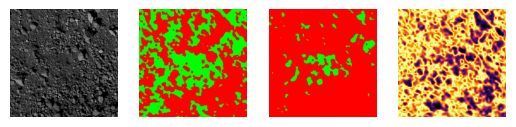

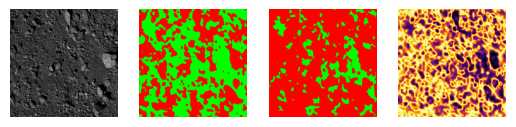

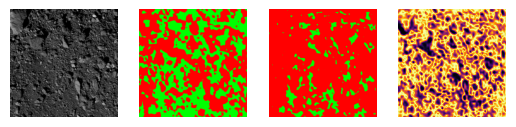

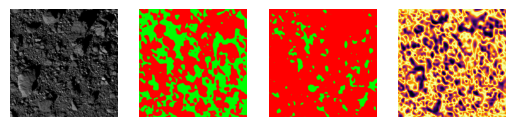

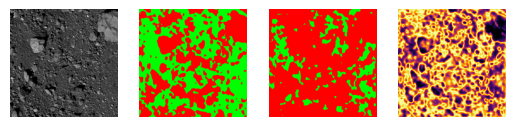

In [6]:
# Uncertainty threshold
ut = 0.3958758559762215

init_dir = os.path.join(data_dir, "init")
entropy_dir = os.path.join(data_dir, "entropy")
os.makedirs(os.path.join(data_dir, "final"), exist_ok=True)
pred_paths = [os.path.join(init_dir, x) for x in os.listdir(init_dir)]
for img_path in image_paths[:5]:

    # Load image.
    img = Image.open(img_path).convert("RGB")
    img_numpy = np.array(img)
    fname = os.path.split(img_path)[1].replace("png", "npy")

    img = T.ToTensor()(img)
    img = torch.FloatTensor(img)
    img = torch.unsqueeze(img, 0)

    # Load initial predictions and entropy.
    pred_init = np.load(os.path.join(init_dir, fname))
    entropy = np.load(os.path.join(entropy_dir, fname))

    # mask uncertain predictions as unsafe
    pred_final = np.copy(pred_init)
    pred_final[entropy > ut] = 0

    pred_init_img = np.zeros((pred_init.shape[0], pred_init.shape[1], 3))
    pred_init_img[:, :, 0] = 1 - pred_init  # red is unsafe
    pred_init_img[:, :, 1] = pred_init   # green is safe

    pred_final_img = np.zeros((pred_final.shape[0], pred_final.shape[1], 3))
    pred_final_img[:, :, 0] = 1 - pred_final  # red is unsafe
    pred_final_img[:, :, 1] = pred_final   # green is safe

    # Visulize results.
    plt.subplot(141)
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.subplot(142)
    plt.imshow(pred_init_img)
    plt.axis("off")
    plt.subplot(143)
    plt.imshow(pred_final_img)
    plt.axis("off")
    plt.subplot(144)
    plt.imshow(entropy, cmap="inferno")
    plt.axis("off")
    plt.show()

    # Save predictions.
    np.save(os.path.join(data_dir, "final", fname), pred_final)